In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from us_states_abbrev import *

In [6]:
covid_path = "data/covid/us_states_covid19_daily.csv"
covid_all_path = "data/covid/us_covid19_daily.csv"
traffic_path = "data/traffic/US_Accidents_June20.csv"
traffic_path_2020_2 = "data/traffic/mq_accidents_2020_2.csv"
traffic_path_2020_2_bing = "data/traffic/bg_accidents_2020_2.csv"
stay_home_order_path = 'data/events/usa_stay_home.csv'

covid_data = pd.read_csv(covid_path, usecols=['date', 'state', 'positive', 'negative', 'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative', 'death'])
covid_all_data = pd.read_csv(covid_all_path, usecols=['date', 'positive'])
traffic_data = pd.read_csv(traffic_path, usecols=['Start_Time', 'State'])
traffic_data = traffic_data.rename(columns={'State': 'state'})

traffic_data_2020_2 = pd.read_csv(traffic_path_2020_2, usecols=['StartTime(UTC)', 'State'])
traffic_data_2020_2 = traffic_data_2020_2.rename(columns={'State': 'state'})
traffic_data_2020_2 = traffic_data_2020_2.rename(columns={'StartTime(UTC)': 'Start_Time'})

traffic_data_2020_2_bing = pd.read_csv(traffic_path_2020_2_bing, usecols=['StartTime(UTC)', 'State'])
traffic_data_2020_2_bing = traffic_data_2020_2.rename(columns={'State': 'state'})
traffic_data_2020_2_bing = traffic_data_2020_2.rename(columns={'StartTime(UTC)': 'Start_Time'})

traffic_data = traffic_data.append(traffic_data_2020_2, ignore_index=True)
traffic_data = traffic_data.append(traffic_data_2020_2_bing, ignore_index=True)

stay_home_order_data = pd.read_csv(stay_home_order_path)

In [7]:
#Convert state 2-letter code to full name
covid_data['state'] = covid_data['state'].map(abbrev_us_state)
traffic_data['state'] = traffic_data['state'].map(abbrev_us_state)

In [8]:
covid_unique = covid_data['state'].unique()
traffic_unique = traffic_data['state'].unique()


In [9]:
#Discovers the states that are included in the Covid dataset but not the traffic dataset
contains = False
difference = []
for covid_state in covid_unique:
    for traffic_state in traffic_unique:
        if covid_state == traffic_state:
            contains = True
    if(contains == False):
        difference.append(covid_state)
    contains = False



In [10]:
# Convert date column to datetime object
covid_data['date'] = pd.to_datetime(covid_data['date'], format='%Y%m%d')
traffic_data['date'] = pd.to_datetime(traffic_data['Start_Time'], format='%Y-%m-%d %H:%M:%S').dt.date
covid_all_data['date'] = pd.to_datetime(covid_all_data['date'], format='%Y%m%d')

# Remove Start_Time column from traffic_data
traffic_data = traffic_data[['date', 'state']]

In [11]:
def get_daily_covid_state(state):

    # Extract the covid data for the given state
    state_covid_data = covid_data.loc[covid_data['state'] == state]

    covid_cumulative = []

    # Iterate each covide positives in state
    for row in state_covid_data['positive']:
        covid_cumulative.insert(0, row)

    covid_none_cumulative = []
    
    covid_none_cumulative.append(covid_cumulative[0])
    for i in range(1, len(covid_cumulative)):
        new_cases = covid_cumulative[i] - covid_cumulative[i-1]
        covid_none_cumulative.append(new_cases)

    covid_none_cumulative.reverse()

    return covid_none_cumulative


In [12]:
def get_daily_covid_contry():

    covid_all = covid_all_data

    covid_cumulative = []

    # Iterate each covide positives
    for row in covid_all['positive']:
        covid_cumulative.insert(0, row)

    covid_none_cumulative = []

    covid_none_cumulative.append(covid_cumulative[0])
    for i in range(1, len(covid_cumulative)):
        new_cases = covid_cumulative[i] - covid_cumulative[i-1]
        covid_none_cumulative.append(new_cases)

    covid_none_cumulative.reverse()

    return covid_none_cumulative

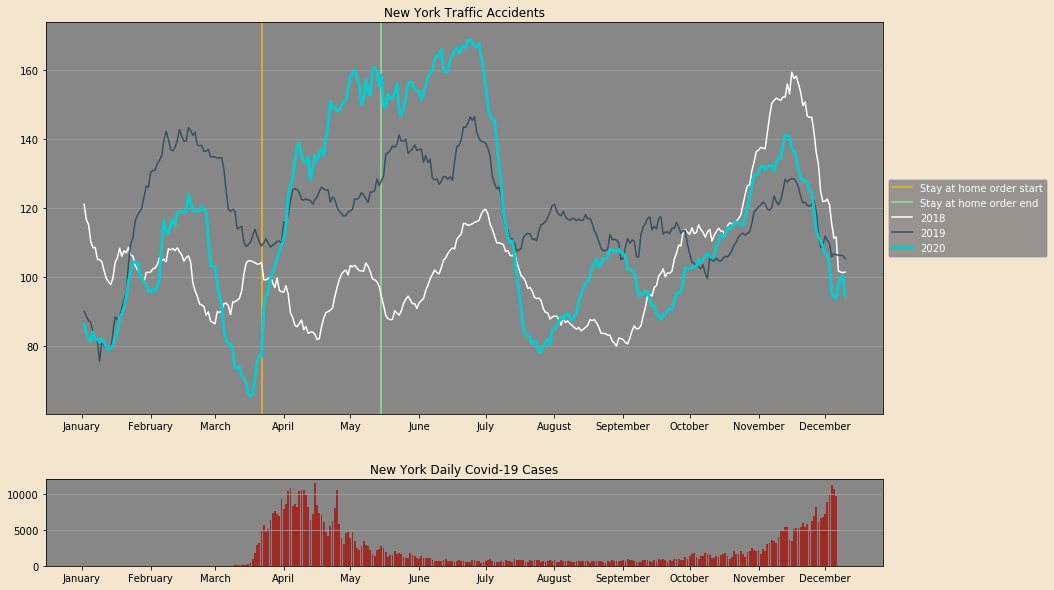

In [16]:
import datetime
def plot_covid_state_bar(state, moving_avg_window):

    # Extract the stay at home order data for the given state
    stay_home_order_state = stay_home_order_data.loc[stay_home_order_data['State'] == state]
    stay_at_home_start_date = None
    stay_at_home_end_date = None

    for row in stay_home_order_state['Stay_Home']:
        if not pd.isnull(row):
            stay_at_home_start_date = row

    for row in stay_home_order_state['End_Home']:
        if not pd.isnull(row):
            stay_at_home_end_date = row

    # Extract the covid data for the given state
    state_covid_data = covid_data.loc[covid_data['state'] == state]

    # Extract the traffic data for the given state
    state_traffic_data = traffic_data.loc[traffic_data['state'] == state]

    # Merge rows with same date and add a counter column
    state_traffic_data['count'] = state_traffic_data.groupby(['date'])['date'].transform('size')
    state_traffic_data.drop_duplicates(keep='first', inplace=True)
    state_traffic_data = state_traffic_data.sort_values(by='date')

    # Apply moving average to data
    state_traffic_data['count'] = state_traffic_data['count'].rolling(window = moving_avg_window).mean()

    # Traffic data 2020
    start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2020 = state_traffic_data.loc[mask]

    # Traffic data 2019
    start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2019-12-10', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2019 = state_traffic_data.loc[mask]
    state_traffic_data_2019['date'] = state_traffic_data_2019['date'] + pd.DateOffset(years=1)
    
    # Traffic data 2018
    start_date = pd.to_datetime('2018-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2018-12-10', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2018 = state_traffic_data.loc[mask]
    state_traffic_data_2018['date'] = state_traffic_data_2018['date'] + pd.DateOffset(years=2)


    # Plot traffic accidents 2020
    dates_traffic_2020 = state_traffic_data_2020['date']
    accidents_2020 = state_traffic_data_2020['count']

    # Plot traffic accidents 2019
    dates_traffic_2019 = state_traffic_data_2019['date']
    accidents_2019 = state_traffic_data_2019['count']

    # Plot taffic accidents 2018
    dates_traffic_2018 = state_traffic_data_2018['date']
    accidents_2018 = state_traffic_data_2018['count']


    fig = plt.figure()

    fig.set_facecolor('#f3e5ce')

    top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)

    # Plot stay at home
    if stay_at_home_start_date != None:
        stay_at_home_start_date = '2020-' + str(stay_at_home_start_date)
        stay_at_home_start_date = datetime.datetime.strptime(stay_at_home_start_date, '%Y-%d-%m').date()
        top.axvline(x=stay_at_home_start_date, color='#F3B61F', label='Stay at home order start')
        
    if stay_at_home_end_date != None:
        stay_at_home_end_date = '2020-' + str(stay_at_home_end_date)
        stay_at_home_end_date = datetime.datetime.strptime(stay_at_home_end_date, '%Y-%d-%m').date()
        top.axvline(x=stay_at_home_end_date, color='#90E39A', label='Stay at home order end')


    top.plot(dates_traffic_2018, accidents_2018, color='white', label='2018') # white
    top.plot(dates_traffic_2019, accidents_2019, color='#37515F', label='2019') #0D5EAB
    top.plot(dates_traffic_2020, accidents_2020, color='#0BC9CD', label='2020', linewidth=3) #FA9500
    plt.title(state + " Traffic Accidents")
    
    top_legend = plt.legend(facecolor='gray', loc='center left', bbox_to_anchor=(1, 0.5))

    # Change font color of legend labels
    for label in top_legend.get_texts():
        label.set_color('white')

    # Add grid to plot background
    plt.grid(which="both", axis="y", color="#9f9f9f")

    # Change axis background color
    top.set_facecolor('#878787')

    # Plot covid cases
    dates_covid = state_covid_data['date']
    positives = get_daily_covid_state(state)
    positives = pd.Series(positives)
    #positives = positives.rolling(window = moving_avg_window).mean()

    # Add the covid along the bottom
    bottom = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4, sharex=top)
    plt.grid(which="both", axis="y", color="#9f9f9f")
    bottom.bar(dates_covid, positives, color='#9E2B25')
    plt.title(state + ' Daily Covid-19 Cases')
    plt.subplots_adjust(hspace=0.75)
    plt.gcf().set_size_inches(15, 10)

    bottom.set_facecolor('#878787')

    # Replace xtick label dates with corresponding month names.
    top.set_xticks(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'])
    top.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    plt.savefig("figures/" + state, dpi=500)



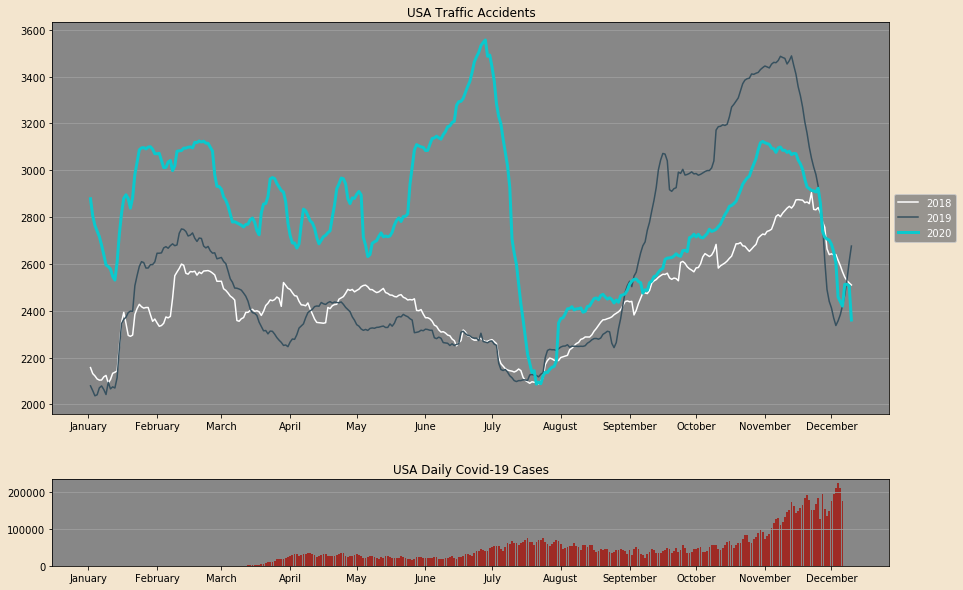

In [14]:
def plot_covid_country_bar(moving_avg_window):

    covid_all = covid_all_data

    all_traffic_data = traffic_data.copy()
    all_traffic_data = all_traffic_data[['date']]

    # Merge rows with the same date and add a counter column
    all_traffic_data['count'] = all_traffic_data.groupby(['date'])['date'].transform('size')
    all_traffic_data.drop_duplicates(keep='first', inplace=True)
    all_traffic_data = all_traffic_data.sort_values(by='date')
    
    # Apply moving average to traffic data
    all_traffic_data['count'] = all_traffic_data['count'].rolling(window = moving_avg_window).mean()

    # Traffic data 2020
    start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', errors='ignore')
    mask = (all_traffic_data['date'] > start_date) & (all_traffic_data['date'] <= end_date)
    all_traffic_data_2020 = all_traffic_data.loc[mask]

    # Traffic data 2019
    start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2019-12-10', format='%Y-%m-%d', errors='ignore')
    mask = (all_traffic_data['date'] > start_date) & (all_traffic_data['date'] <= end_date)
    all_traffic_data_2019 = all_traffic_data.loc[mask]
    all_traffic_data_2019['date'] = all_traffic_data_2019['date'] + pd.DateOffset(years=1)
    
    # Traffic data 2018
    start_date = pd.to_datetime('2018-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2018-12-10', format='%Y-%m-%d', errors='ignore')
    mask = (all_traffic_data['date'] > start_date) & (all_traffic_data['date'] <= end_date)
    all_traffic_data_2018 = all_traffic_data.loc[mask]
    all_traffic_data_2018['date'] = all_traffic_data_2018['date'] + pd.DateOffset(years=2)


    # Plot traffic accidents 2020
    dates_traffic_2020 = all_traffic_data_2020['date']
    accidents_2020 = all_traffic_data_2020['count']

    # Plot traffic accidents 2019
    dates_traffic_2019 = all_traffic_data_2019['date']
    accidents_2019 = all_traffic_data_2019['count']

    # Plot taffic accidents 2018
    dates_traffic_2018 = all_traffic_data_2018['date']
    accidents_2018 = all_traffic_data_2018['count']

    
    fig = plt.figure()
    fig.set_facecolor('#f3e5ce')

    top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)


    top.plot(dates_traffic_2018, accidents_2018, color='white', label='2018') # white
    top.plot(dates_traffic_2019, accidents_2019, color='#37515F', label='2019') #0D5EAB
    top.plot(dates_traffic_2020, accidents_2020, color='#0BC9CD', label='2020', linewidth=3) #FA9500
    plt.title("USA Traffic Accidents")
    
    top_legend = plt.legend(facecolor='gray', loc='center left', bbox_to_anchor=(1, 0.5))

    # Change font color of legend labels
    for label in top_legend.get_texts():
        label.set_color('white')

    # Add grid to plot background
    plt.grid(which="both", axis="y", color="#9f9f9f")

    # Change axis background color
    top.set_facecolor('#878787')

    # Plot covid cases
    dates_covid = covid_all['date']
    positives = get_daily_covid_contry()
    positives = pd.Series(positives)
    #positives = positives.rolling(window = moving_avg_window).mean()

    # Add the covid along the bottom
    bottom = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4, sharex=top)
    plt.grid(which="both", axis="y", color="#9f9f9f")
    bottom.bar(dates_covid, positives, color='#9E2B25')
    plt.title('USA Daily Covid-19 Cases')
    plt.subplots_adjust(hspace=0.75)
    plt.gcf().set_size_inches(15, 10)

    bottom.set_facecolor('#878787')

    # Replace xtick label dates with corresponding month names.
    top.set_xticks(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'])
    top.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    plt.savefig("figures/USA", dpi=500)



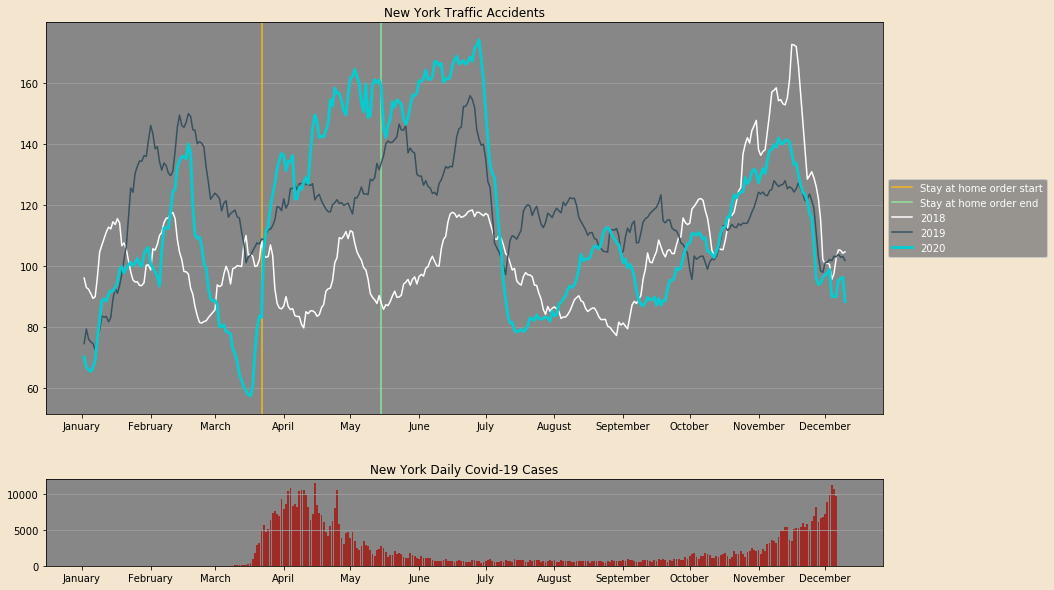

In [15]:
plot_covid_country_bar(21)
plot_covid_state_bar('New York', 21)